In [1]:
#Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from tqdm.notebook import tqdm
from torchvision.utils import save_image

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor()
])

# train data
TRAIN_DATA_PATH = "./filter_extracted_cells/train/"
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=64, shuffle=True)

# test data
TEST_DATA_PATH = "./filter_extracted_cells/test/"
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=64, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [13]:
# dimensions of latent space
zdim = 10


# Variational Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # encoder
        self.fc1 = nn.Linear(128 * 128, 64*64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64 * 64, 350)
        self.fc2m = nn.Linear(350, zdim)  # mu layer
        self.fc2s = nn.Linear(350, zdim)  # sd layer

        # decoder
        self.fc3 = nn.Linear(zdim, 64 * 64)
        self.fc4 = nn.Linear(64 * 64, 350)
        self.fc5 = nn.Linear(350, 128 * 128)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        return self.fc2m(h2), self.fc2s(h2)

    # reparameterize
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        h4 = self.relu(self.fc4(h3))
        return self.sigmoid(self.fc5(h4))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 128 * 128))
        z = self.reparameterize(mu, logvar)
        val = self.decode(z)
        return val, mu, logvar

In [14]:

# loss function for VAE are unique and use Kullback-Leibler
# divergence measure to force distribution to match unit Gaussian
def loss_function(recon_x, x, mu, logvar):
    #     print(x.view(-1, 28 * 28))
    bce = F.binary_cross_entropy(recon_x, x.view(-1, 128 * 128))
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kld /= 64 * 128 * 128
    return bce + kld


def train(model, num_epochs=1, batch_size=64, learning_rate=1e-3):
    model.train()  #train mode
    torch.manual_seed(42)

    # train_loader = torch.utils.data.DataLoader(
    #     train_data,
    #     batch_size=batch_size, shuffle=True)

    optimizer = optim.Adam(model.parameters(), learning_rate)

    for epoch in tqdm(range(num_epochs)):
        for data in train_loader:  # load batch
            img, _ = data
            img = img.to(device)

            recon, mu, logvar = model(img)
            loss = loss_function(recon, img, mu, logvar)  # calculate loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch + 1, float(loss)))

In [6]:
model = Autoencoder()
model = model.to(device)
model.load_state_dict(torch.load("./vae_cell.pt"))

<All keys matched successfully>

In [15]:
model = Autoencoder()
model = model.to(device)
train(model, num_epochs=100, batch_size=128, learning_rate=0.005)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:1, Loss:0.7069
Epoch:2, Loss:0.6857
Epoch:3, Loss:0.6831
Epoch:4, Loss:0.6819
Epoch:5, Loss:0.6781
Epoch:6, Loss:0.6789
Epoch:7, Loss:0.6765
Epoch:8, Loss:0.6867
Epoch:9, Loss:0.6847
Epoch:10, Loss:0.6805
Epoch:11, Loss:0.6815
Epoch:12, Loss:0.6846
Epoch:13, Loss:0.6766
Epoch:14, Loss:0.6690
Epoch:15, Loss:0.6781
Epoch:16, Loss:0.6851
Epoch:17, Loss:0.6811
Epoch:18, Loss:0.6771
Epoch:19, Loss:0.6753
Epoch:20, Loss:0.6827
Epoch:21, Loss:0.6766
Epoch:22, Loss:0.6638
Epoch:23, Loss:0.6881
Epoch:24, Loss:0.6785
Epoch:25, Loss:0.6768
Epoch:26, Loss:0.6841
Epoch:27, Loss:0.6790
Epoch:28, Loss:0.6906
Epoch:29, Loss:0.6851
Epoch:30, Loss:0.6875
Epoch:31, Loss:0.6863
Epoch:32, Loss:0.6880
Epoch:33, Loss:0.6817
Epoch:34, Loss:0.6804
Epoch:35, Loss:0.6700
Epoch:36, Loss:0.6781
Epoch:37, Loss:0.6732
Epoch:38, Loss:0.6744
Epoch:39, Loss:0.6744
Epoch:40, Loss:0.6795
Epoch:41, Loss:0.6744
Epoch:42, Loss:0.6752
Epoch:43, Loss:0.6826
Epoch:44, Loss:0.6701
Epoch:45, Loss:0.6859
Epoch:46, Loss:0.68

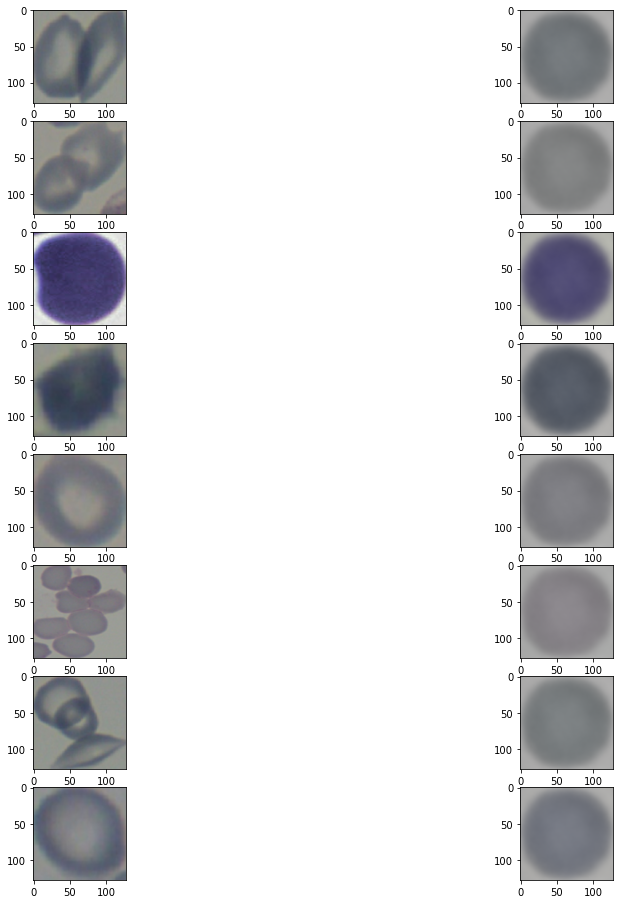

In [7]:
"""
The following part takes a random image from test loader to feed into the VAE.
Both the original image and generated image from the distribution are shown.
"""

import matplotlib.pyplot as plt
import numpy as np
import random

plt.figure(figsize=(16, 16))
model.eval()
with torch.no_grad():
    for data in random.sample(list(test_loader), 1):
        imgs, _ = data
        # print(data)
        imgs = imgs.to(device)
        for i in range(8):
            img = np.transpose(imgs[i].cpu().numpy(), [1,2,0])
            plt.subplot(8, 2, 2*i+1)
            plt.imshow(np.squeeze(img))
            out, mu, logVAR = model(imgs)
            out = out.reshape(imgs.shape)
            outimg = np.transpose(out[i].cpu().numpy(), [1,2,0])
            plt.subplot(8, 2, 2*i+2)
            plt.imshow(np.squeeze(outimg))
        break

In [11]:
imgs[i]

tensor([[[0.5451, 0.5608, 0.5647,  ..., 0.5569, 0.5569, 0.5569],
         [0.5451, 0.5569, 0.5608,  ..., 0.5569, 0.5569, 0.5608],
         [0.5451, 0.5529, 0.5608,  ..., 0.5569, 0.5569, 0.5569],
         ...,
         [0.5569, 0.5569, 0.5569,  ..., 0.3765, 0.3804, 0.3804],
         [0.5569, 0.5569, 0.5569,  ..., 0.3804, 0.3843, 0.3843],
         [0.5569, 0.5608, 0.5608,  ..., 0.3843, 0.3922, 0.3882]],

        [[0.5686, 0.5686, 0.5686,  ..., 0.5608, 0.5608, 0.5608],
         [0.5647, 0.5686, 0.5686,  ..., 0.5608, 0.5608, 0.5647],
         [0.5608, 0.5686, 0.5686,  ..., 0.5608, 0.5608, 0.5608],
         ...,
         [0.5608, 0.5569, 0.5569,  ..., 0.4039, 0.4078, 0.4157],
         [0.5608, 0.5569, 0.5569,  ..., 0.4000, 0.4078, 0.4157],
         [0.5608, 0.5608, 0.5608,  ..., 0.4039, 0.4039, 0.4118]],

        [[0.5686, 0.5765, 0.5765,  ..., 0.5765, 0.5804, 0.5804],
         [0.5647, 0.5725, 0.5804,  ..., 0.5765, 0.5804, 0.5843],
         [0.5608, 0.5725, 0.5804,  ..., 0.5765, 0.5804, 0.

In [41]:
torch.save(model.state_dict(), "./vae_cell.pt")

In [2]:
"""
A Convolutional Variational Autoencoder
"""
class ConvolutionalVAE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=32*116*116, zDim=20):
        super(ConvolutionalVAE, self).__init__()

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 16, 7)
        self.encConv2 = nn.Conv2d(16, 32, 7)
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)
        self.flatten = nn.Flatten()

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 7)
        self.decConv2 = nn.ConvTranspose2d(16, imgChannels, 7)

    def encoder(self, x):

        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = x.view(-1, 32*116*116)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC1(z))
        x = x.view(-1, 32, 116, 116)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x

    def forward(self, x):

        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar

In [ ]:
"""
A Convolutional Variational Autoencoder
"""
class ConvolutionalVAE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=32*10*10, zDim=20):
        super(ConvolutionalVAE, self).__init__()

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 12, 3, 1, 1)
        self.encConv2 = nn.Conv2d(12, 14, 3, 1, 1)
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)
        self.flatten = nn.Flatten()

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(14, 12, 3, 1, 1)
        self.decConv2 = nn.ConvTranspose2d(12, imgChannels, 3, 1, 1)

    def encoder(self, x):

        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = x.view(-1, 32*116*116)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC1(z))
        x = x.view(-1, 32, 116, 116)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x

    def forward(self, x):

        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar

In [6]:
"""
Initialize Hyperparameters
"""
batch_size = 64
learning_rate = 1e-3
num_epochs = 200



"""
Initialize the network and the Adam optimizer
"""
net = ConvolutionalVAE(imgChannels=3).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [7]:


"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
for epoch in range(num_epochs):
    for idx, data in enumerate(train_loader, 0):
        imgs, _ = data
        imgs = imgs.to(device)

        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = net(imgs)

        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(out, imgs, size_average=False) + kl_divergence

        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch {}: Loss {}'.format(epoch, loss))

C:\Users\quick\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: Loss 615348.5
Epoch 1: Loss 613395.5625
Epoch 2: Loss 612748.3125
Epoch 3: Loss 611865.5625
Epoch 4: Loss 604707.125
Epoch 5: Loss 598667.5
Epoch 6: Loss 594400.625
Epoch 7: Loss 610858.6875
Epoch 8: Loss 592919.5
Epoch 9: Loss 578740.9375
Epoch 10: Loss 591589.5
Epoch 11: Loss 574401.25
Epoch 12: Loss 566137.6875
Epoch 13: Loss 589626.1875
Epoch 14: Loss 577603.4375
Epoch 15: Loss 558412.375
Epoch 16: Loss 569359.5625
Epoch 17: Loss 567405.0625
Epoch 18: Loss 556126.0
Epoch 19: Loss 592758.125
Epoch 20: Loss 568328.75
Epoch 21: Loss 568311.5625
Epoch 22: Loss 575945.9375
Epoch 23: Loss 538346.4375
Epoch 24: Loss 578521.4375
Epoch 25: Loss 579289.125
Epoch 26: Loss 578519.125
Epoch 27: Loss 589176.625
Epoch 28: Loss 572915.6875
Epoch 29: Loss 533639.1875
Epoch 30: Loss 561570.0625
Epoch 31: Loss 570905.5625
Epoch 32: Loss 574346.3125
Epoch 33: Loss 581802.4375
Epoch 34: Loss 561271.9375
Epoch 35: Loss 593748.4375
Epoch 36: Loss 570485.625
Epoch 37: Loss 579027.4375
Epoch 38: L

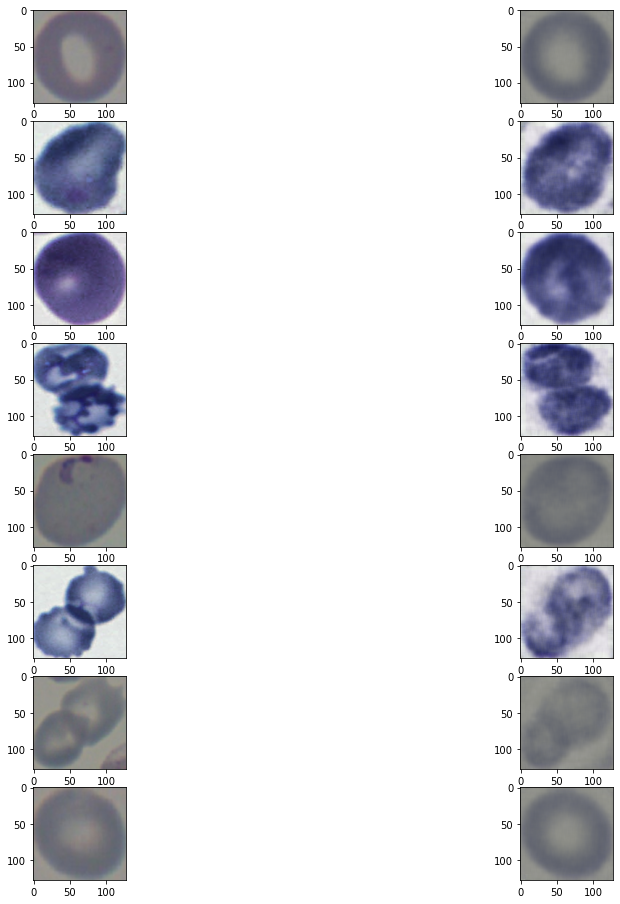

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import random

plt.figure(figsize=(16, 16))
# model.eval()
with torch.no_grad():
    for data in random.sample(list(test_loader), 1):
        imgs, _ = data
        # print(data)
        imgs = imgs.to(device)
        for i in range(8):
            img = np.transpose(imgs[i].cpu().numpy(), [1,2,0])
            plt.subplot(8, 2, 2*i+1)
            plt.imshow(np.squeeze(img))
            out, mu, logVAR = net(imgs)
            out = out.reshape(imgs.shape)
            outimg = np.transpose(out[i].cpu().numpy(), [1,2,0])
            plt.subplot(8, 2, 2*i+2)
            plt.imshow(np.squeeze(outimg))
        break

In [9]:
torch.save(net.state_dict(), "./vae_cell_conv.pt")

In [10]:
net.eval()

ConvolutionalVAE(
  (encConv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1))
  (encConv2): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1))
  (encFC1): Linear(in_features=430592, out_features=20, bias=True)
  (encFC2): Linear(in_features=430592, out_features=20, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (decFC1): Linear(in_features=20, out_features=430592, bias=True)
  (decConv1): ConvTranspose2d(32, 16, kernel_size=(7, 7), stride=(1, 1))
  (decConv2): ConvTranspose2d(16, 3, kernel_size=(7, 7), stride=(1, 1))
)